##Zouari Adam

In [ ]:
import gdown
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
import joblib  # For saving models

There are 3 files: Ack-flood.csv, Syn-flood.csv and DoS_BENIGN.csv

In [ ]:
df1 = pd.read_csv("Ack-flood.csv")
df2 = pd.read_csv("Syn-flood.csv")
df3 = pd.read_csv("DoS_BENIGN.csv")

Adding labels for BENIGN and DoS flows and merging the datasets into one.

Additionally, balancing the dataset by equalizing the number of BENIGN and DoS flows.

In [ ]:
df3['Label']='BENIGN'

df = pd.concat([df1, df2], axis=0)


# Fill the 'Label' column with 'DoS'
df['Label'] = 'DoS'

df = pd.concat([df, df3], axis=0)


# Define the target size (minimum count of remaining classes)
target_size = df['Label'].value_counts().min()

# Undersample remaining classes
df_balanced = df.groupby('Label').apply(lambda x: x.sample(target_size, random_state=42)).reset_index(drop=True)

# Save back to CSV (optional)
df_balanced.to_csv('DoS.csv', index=False)

In [ ]:
df=df_balanced

In [ ]:
df=pd.read_csv('DoS.csv')

Checking the dataset balance.

In [ ]:
print(df['Label'].value_counts())

Label
BENIGN    19927
DoS       19927
Name: count, dtype: int64


Checking for null values in the dataset.

In [ ]:
print("\nTotal NaN values in the dataset:", df.isna().sum().sum())


Total NaN values in the dataset: 17


Checking columns containing NaN values.

In [ ]:
for column in df.columns:
    print(f"NaN values in {column}: {df[column].isna().sum()}")

NaN values in Flow ID: 0
NaN values in Src IP: 0
NaN values in Src Port: 0
NaN values in Dst IP: 0
NaN values in Dst Port: 0
NaN values in Protocol: 0
NaN values in Timestamp: 0
NaN values in Flow Duration: 0
NaN values in Total Fwd Packet: 0
NaN values in Total Bwd packets: 0
NaN values in Total Length of Fwd Packet: 0
NaN values in Total Length of Bwd Packet: 0
NaN values in Fwd Packet Length Max: 0
NaN values in Fwd Packet Length Min: 0
NaN values in Fwd Packet Length Mean: 0
NaN values in Fwd Packet Length Std: 0
NaN values in Bwd Packet Length Max: 0
NaN values in Bwd Packet Length Min: 0
NaN values in Bwd Packet Length Mean: 0
NaN values in Bwd Packet Length Std: 0
NaN values in Flow Bytes/s: 17
NaN values in Flow Packets/s: 0
NaN values in Flow IAT Mean: 0
NaN values in Flow IAT Std: 0
NaN values in Flow IAT Max: 0
NaN values in Flow IAT Min: 0
NaN values in Fwd IAT Total: 0
NaN values in Fwd IAT Mean: 0
NaN values in Fwd IAT Std: 0
NaN values in Fwd IAT Max: 0
NaN values in Fwd

In [ ]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

Checking for the presence of infinite values (inf).

In [ ]:
import numpy as np

# Identify columns with inf values
inf_columns = numeric_df.columns[np.isinf(numeric_df).any()].tolist()

# Print result
print("Columns containing infinity values:", inf_columns)

Columns containing infinity values: ['Flow Bytes/s', 'Flow Packets/s']


In [ ]:
# Check for inf values in the specific columns
inf_counts = df[['Flow Bytes/s', 'Flow Packets/s']].applymap(np.isinf).sum()

# Display the number of infinite values per column
print("Number of infinite values in 'Flow Bytes/s' and 'Flow Packets/s':\n", inf_counts)

Number of infinite values in 'Flow Bytes/s' and 'Flow Packets/s':
 Flow Bytes/s      138
Flow Packets/s    155
dtype: int64


<ipython-input-190-6810c7813482>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  inf_counts = df[['Flow Bytes/s', 'Flow Packets/s']].applymap(np.isinf).sum()


The columns 'Flow Bytes/s' and 'Flow Packets/s' contain infinite values (inf), but these features are important for classification. This is why removing infinite values and NaN is essential.

In [ ]:
# Replace inf values with NaN
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values
df = df.dropna(subset=["Flow Bytes/s", "Flow Packets/s"])

Label encoding

In [ ]:
# Encode target labels
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])

0 corresponds to BENIGN and 1 corresponds to DoS.

In [ ]:
# Display the mapping of class labels to encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping: ", label_mapping)

Label Mapping:  {'BENIGN': np.int64(0), 'DoS': np.int64(1)}


### Data Augmentation

In [ ]:
import pandas as pd
import numpy as np

def augment_dos_data(df, augmentation_factor=1, noise_scale1=0.05, noise_scale2=10):
    """
    Augments DoS attack rows with different noise scales for different features.

    Parameters:
    - df: Input DataFrame with network traffic data
    - augmentation_factor: Number of noisy copies to create
    - noise_scale1: Noise scale for Flow Packets/s (default 1%)
    - noise_scale2: Noise scale for all other numeric features (default 5%)

    Returns:
    - DataFrame with original benign traffic and augmented DoS traffic only
    """
    # Define feature columns (all numeric except Label)
    feature_cols = [
        'Flow Duration',
        'Total Fwd Packet',
        'Fwd Packet Length Mean',
        'Flow Bytes/s',
        'Flow Packets/s',
        'Flow IAT Mean',
        'FIN Flag Count',
        'SYN Flag Count',
        'RST Flag Count',
        'ACK Flag Count',
        'Label'
    ]

    # Create working copy with only needed columns
    df_working = df[feature_cols].copy()

    # Split into DoS and benign traffic
    df_benign = df_working[df_working['Label'] == 0]
    df_dos = df_working[df_working['Label'] == 1]

    # Create list to hold augmented DoS versions
    augmented_dos_versions = []

    # Define which columns get which noise scale
    packets_col = ['Flow Packets/s']
    other_numeric_cols = [col for col in feature_cols if col != 'Label' and col != 'Flow Packets/s']
    integer_cols = ['Flow Duration', 'Total Fwd Packet', 'FIN Flag Count',
                   'SYN Flag Count', 'RST Flag Count', 'ACK Flag Count']

    for _ in range(augmentation_factor):
        noisy_dos = df_dos.copy()

        # Apply noise_scale1 to Flow Packets/s
        noise1 = np.random.uniform(
            low=-noise_scale1,
            high=noise_scale1,
            size=df_dos[packets_col].shape
        )
        noisy_dos[packets_col] = noisy_dos[packets_col] * (1 + noise1)

        # Apply noise_scale2 to other numeric features
        noise2 = np.random.uniform(
            low=-noise_scale2,
            high=noise_scale2,
            size=df_dos[other_numeric_cols].shape
        )
        noisy_dos[other_numeric_cols] = np.abs(noisy_dos[other_numeric_cols] * (1 + noise2))

        # Round integer columns
        noisy_dos[integer_cols] = noisy_dos[integer_cols].round().astype(int)

        augmented_dos_versions.append(noisy_dos)

    # Combine original benign with augmented DoS only
    result = pd.concat([df_benign] + augmented_dos_versions)

    return result.reset_index(drop=True)

In [ ]:
df_augmented = augment_dos_data(df)
print(df_augmented.shape)
print(df.shape)

### Selection of relevant features

In [ ]:
df_augmented = augment_dos_data(df)
print(df_augmented.shape)
print(df.shape)

# Split features and label
X = df[['Flow Duration',
                  'Total Fwd Packet',
                  'Fwd Packet Length Mean',
                  'Flow Bytes/s',
                  'Flow Packets/s',
                  'Flow IAT Mean',
                  'FIN Flag Count',
                  'SYN Flag Count',
                  'RST Flag Count',
                  'ACK Flag Count']]

y = df['Label']

(39699, 10)
(39699, 84)


Splitting the data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Data standardization.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Testing different models with regularization to identify the best one while avoiding overfitting.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

models = {
    # Regularized Logistic Regression (L2 penalty)
    "Logistic Regression": LogisticRegression(
        C=0.01, penalty="l2", solver="lbfgs", max_iter=1000
    ),

    # Decision Tree (pruned to avoid overfitting)
    "Decision Tree": DecisionTreeClassifier(
        max_depth=5, min_samples_split=10, random_state=42
    ),

    # Random Forest (ensemble of decision trees)
    "Random Forest": RandomForestClassifier(
        n_estimators=100, max_depth=5, random_state=42
    ),

    # Support Vector Machine (RBF kernel)
    "SVM": SVC(
        C=1.0, kernel="rbf", gamma="scale", random_state=42
    ),

    # k-Nearest Neighbors (weighted by distance)
    "KNN": KNeighborsClassifier(
        n_neighbors=5, weights="distance"
    ),

    # Gradient Boosting (sequential tree boosting)
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ),

    # XGBoost (optimized gradient boosting)
    "XGBoost": XGBClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ),

    # Naive Bayes (Gaussian assumptions)
    "Naive Bayes": GaussianNB()
}

Training and evaluating models to select the best one.

In [ ]:
# Evaluate models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None).mean()  # Normal precision
    recall = recall_score(y_test, y_pred, average=None).mean()  # Normal recall
    f1 = f1_score(y_test, y_pred, average=None).mean()  # Normal F1-score

    results.append([name, accuracy, precision, recall, f1])

    # Save each model
    joblib.dump(model, f"{name}_model.joblib")

# Convert results to DataFrame
metrics_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"])

# Print results
print("\n📊 Model Evaluation Metrics:\n")
print(metrics_df)

# Display detailed classification report for the best model
best_model_name = metrics_df.sort_values(by="Accuracy", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]
y_best_pred = best_model.predict(X_test)

print(f"\n🔹 Best Model: {best_model_name}")
print("Classification Report:\n", classification_report(y_test, y_best_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_best_pred))


📊 Model Evaluation Metrics:

                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.994836   0.994909  0.994815  0.994836
1        Decision Tree  0.999874   0.999874  0.999875  0.999874
2        Random Forest  0.999748   0.999747  0.999749  0.999748
3                  SVM  0.998866   0.998874  0.998862  0.998866
4                  KNN  0.999874   0.999874  0.999875  0.999874
5    Gradient Boosting  0.999622   0.999622  0.999623  0.999622
6              XGBoost  0.999874   0.999874  0.999875  0.999874
7          Naive Bayes  1.000000   1.000000  1.000000  1.000000

🔹 Best Model: Naive Bayes
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3954
           1     1.0000    1.0000    1.0000      3986

    accuracy                         1.0000      7940
   macro avg     1.0000    1.0000    1.0000      7940
weighted avg     1.0000    1.0000    1.0000      7940

Confusion Matrix

After many trials, careful hyperparameter tuning, and applying regularization techniques to address overfitting and low recall issues, logistic regression proved to be the best choice.

In [ ]:
from sklearn.linear_model import LogisticRegression

models = {

    "Logistic Regression": LogisticRegression(
        C=0.01, penalty="l2", solver="lbfgs", max_iter=1000
    ),  # Regularized logistic regression (L2)

}

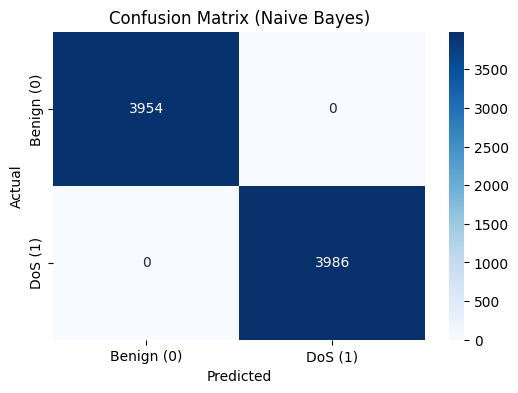

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assume:
# - y_test = true labels
# - y_best_pred = predictions from best_model

cm = confusion_matrix(y_test, y_best_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign (0)', 'DoS (1)'],
            yticklabels=['Benign (0)', 'DoS (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix ({best_model_name})')
plt.show()